# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


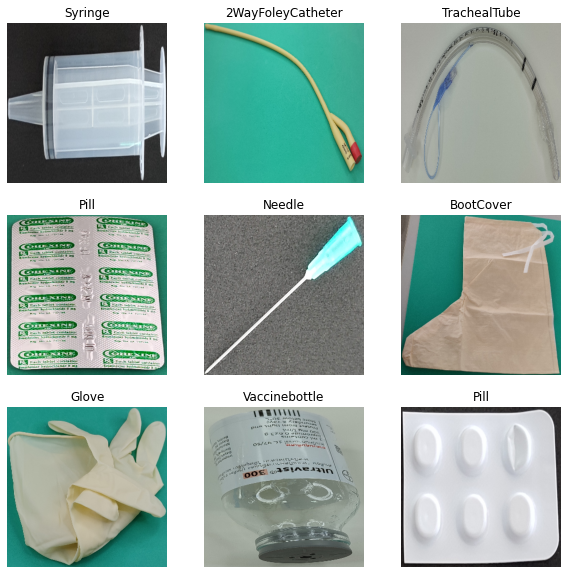

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
tf.keras.utils.plot_model(custom_inceptionv3_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 41)                21033     
Total params: 24,446,793
Trainable params: 2,644,009
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
print(len(model.layers))
tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

5


# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense1024-512-NoClassImbalanced-NoAug-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 43s 329ms/step - loss: 1.4589 - accuracy: 0.6016 - val_loss: 0.7119 - val_accuracy: 0.7671
Epoch 2/2000
49/49 [==============================] - 9s 183ms/step - loss: 0.4826 - accuracy: 0.8481 - val_loss: 0.3569 - val_accuracy: 0.8900
Epoch 3/2000
49/49 [==============================] - 9s 182ms/step - loss: 0.2708 - accuracy: 0.9160 - val_loss: 0.2862 - val_accuracy: 0.9043
Epoch 4/2000
49/49 [==============================] - 9s 183ms/step - loss: 0.1469 - accuracy: 0.9515 - val_loss: 0.2435 - val_accuracy: 0.9185
Epoch 5/2000
49/49 [==============================] - 9s 183ms/step - loss: 0.0872 - accuracy: 0.9738 - val_loss: 0.2087 - val_accuracy: 0.9263
Epoch 6/2000
49/49 [==============================] - 9s 183ms/step - loss: 0.0505 - accuracy: 0.9880 - val_loss: 0.2073 - val_accuracy: 0.9366
Epoch 7/2000
49/49 [==============================] - 9s 183ms/step - loss: 0.0378 - accuracy: 0.9897 - val_loss: 0.1546 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

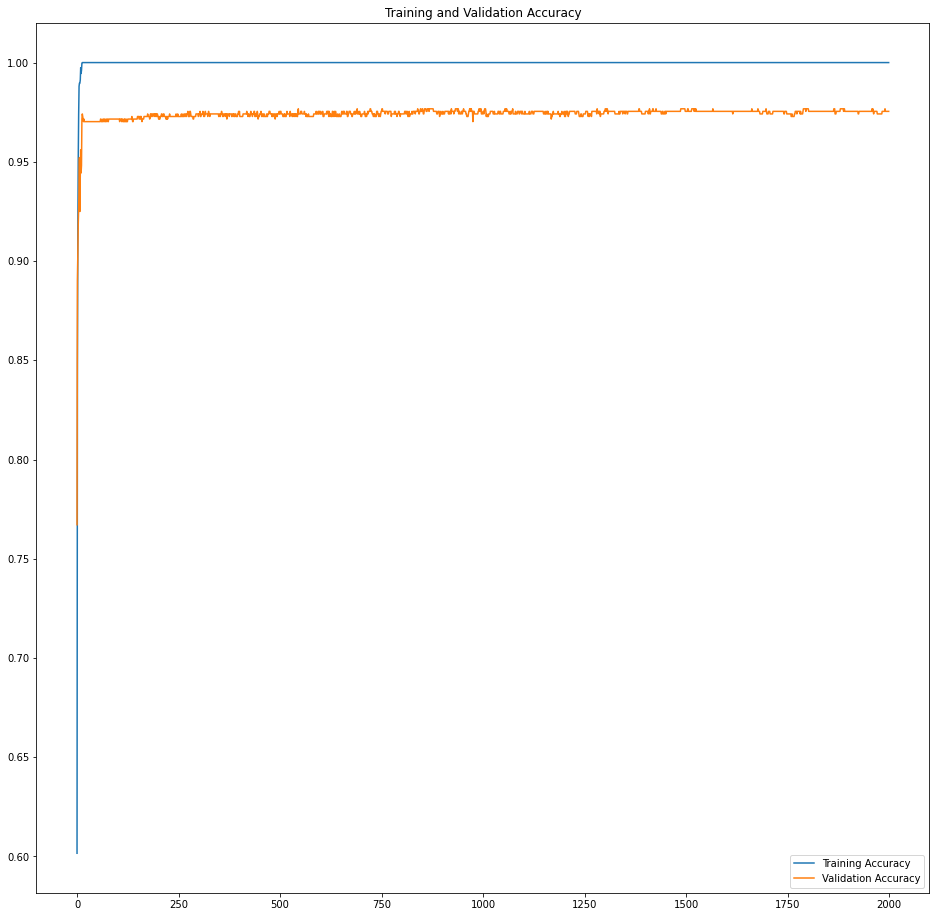

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


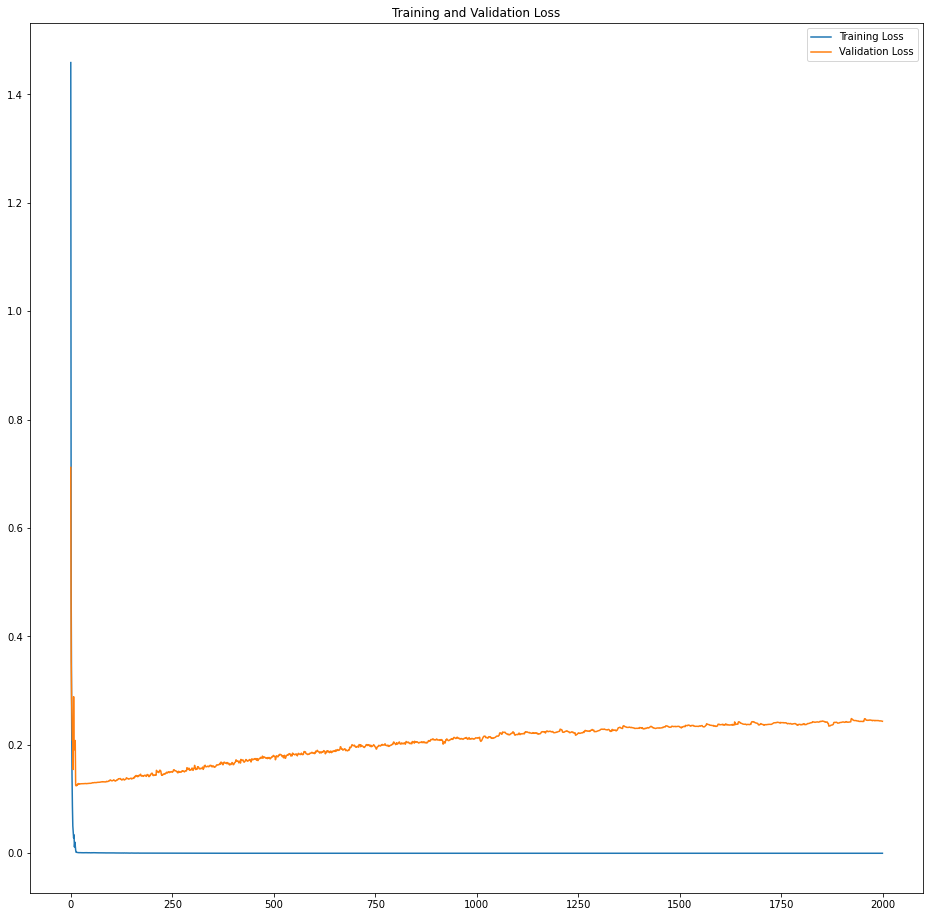

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 331ms/step - loss: 1.0587 - accuracy: 0.8434
test_indoor_ds_results:test loss, test acc: [1.0586875677108765, 0.843366801738739]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 438ms/step - loss: 2.7843 - accuracy: 0.7436
test_outdoor_ds_results:test loss, test acc: [2.7842674255371094, 0.743630588054657]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 204ms/step - loss: 3.2758 - accuracy: 0.6868
test_belt_ds_results:test loss, test acc: [3.2758092880249023, 0.686763346195221]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense1024-512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense1024-512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense1024-512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense1024-512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense1024-512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedic

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 140ms/step - loss: 1.7793 - accuracy: 0.6741
Epoch040 
 test_indoor_acc=0.8394649028778076 
 test_outdoor_acc=0.7318471074104309 
 test_belt_acc=0.6740707159042358
35/35 [==============================] - 5s 139ms/step - loss: 1.8223 - accuracy: 0.6763
Epoch080 
 test_indoor_acc=0.8383500576019287 
 test_outdoor_acc=0.7289808988571167 
 test_belt_acc=0.6763372421264648
35/35 [==============================] - 5s 142ms/step - loss: 1.9016 - accuracy: 0.6754
Epoch120 
 test_indoor_acc=0.8338907361030579 
 test_outdoor_acc=0.7286624312400818 
 test_belt_acc=0.6754306554794312
35/35 [==============================] - 5s 142ms/step - loss: 1.9570 - accuracy: 0.6782
Epoch160 
 test_indoor_acc=0.8389074802398682 
 test_outdoor_acc=0.7340764403343201 
 test_belt_acc=0.678150475025177
35/35 [==============================] - 5s 142ms/step - loss: 2.0759 - accuracy: 0.6759
Epoch200 
 test_indoor_acc=0.8344481587409973 
 test_outdoor_acc=0.7347133755683

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

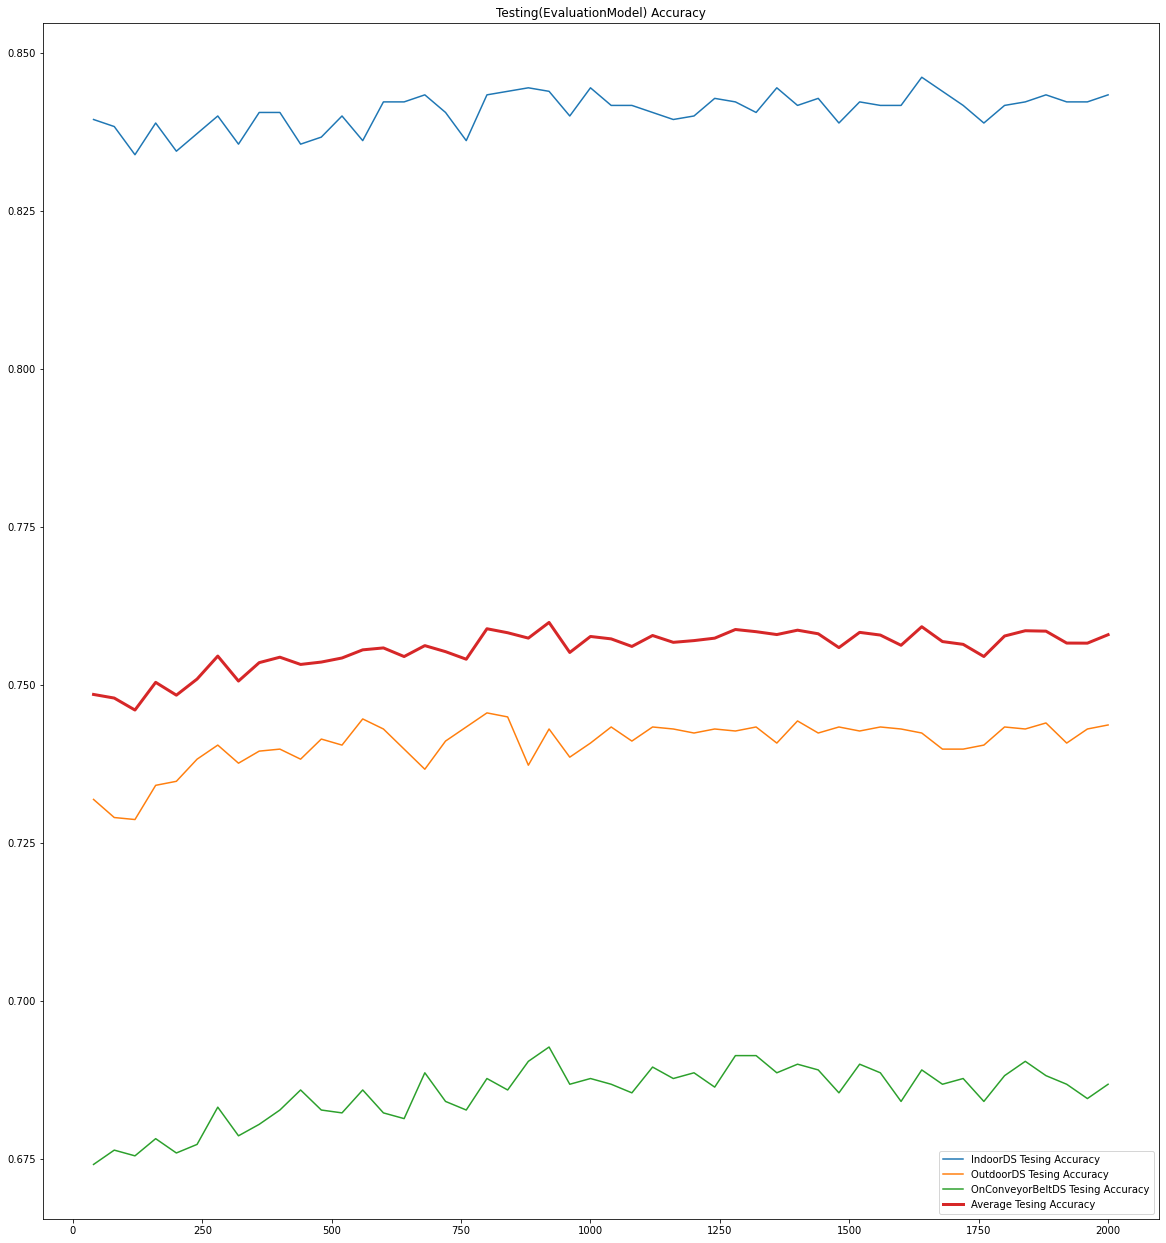

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7598580718040466
max index -> 22
The [Epoch] of max acc -> 920


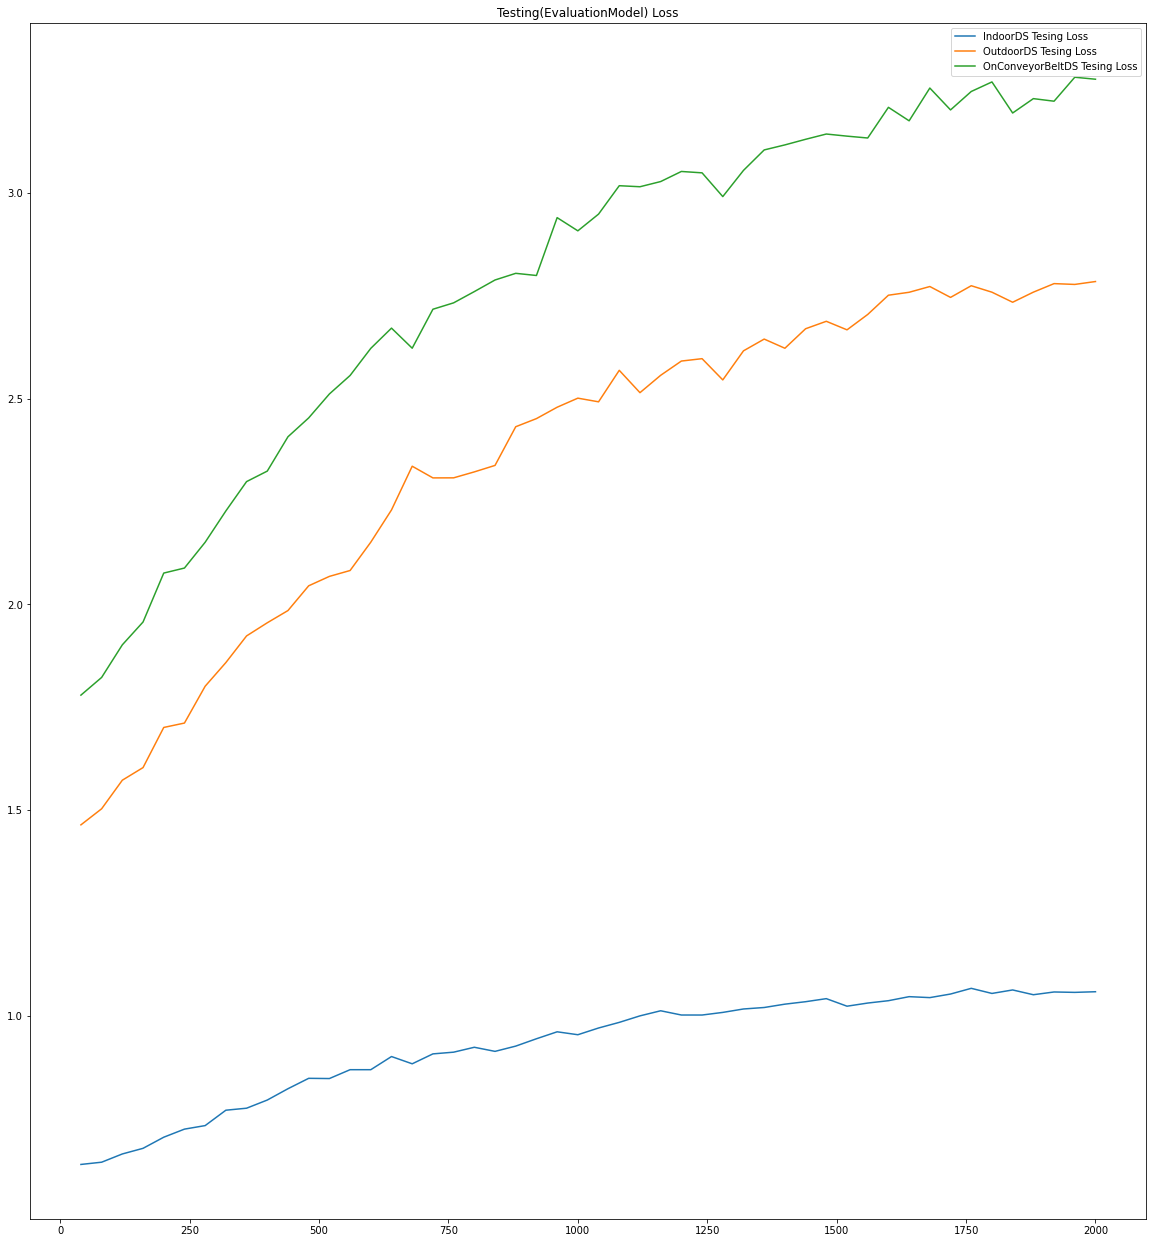

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.8394649028778076,
 0.8383500576019287,
 0.8338907361030579,
 0.8389074802398682,
 0.8344481587409973,
 0.8372352123260498,
 0.8400223255157471,
 0.8355630040168762,
 0.8405796885490417,
 0.8405796885490417,
 0.8355630040168762,
 0.8366777896881104,
 0.8400223255157471,
 0.8361204266548157,
 0.8422519564628601,
 0.8422519564628601,
 0.843366801738739,
 0.8405796885490417,
 0.8361204266548157,
 0.843366801738739,
 0.8439241647720337,
 0.8444815874099731,
 0.8439241647720337,
 0.8400223255157471,
 0.8444815874099731,
 0.8416945338249207,
 0.8416945338249207,
 0.8405796885490417,
 0.8394649028778076,
 0.8400223255157471,
 0.8428093791007996,
 0.8422519564628601,
 0.8405796885490417,
 0.8444815874099731,
 0.8416945338249207,
 0.8428093791007996,
 0.8389074802398682,
 0.8422519564628601,
 0.8416945338249207,
 0.8416945338249207,
 0.8461538553237915,
 0.8439241647720337,
 0.8416945338249207,
 0.8389074802398682,
 0.8416945338249207,
 0.8422519564628601,
 0.843366801738739,
 0.8422519564628

In [38]:
test_outdoor_acc

[0.7318471074104309,
 0.7289808988571167,
 0.7286624312400818,
 0.7340764403343201,
 0.7347133755683899,
 0.7382165789604187,
 0.7404458522796631,
 0.7375796437263489,
 0.7394904494285583,
 0.7398089170455933,
 0.7382165789604187,
 0.7414012551307678,
 0.7404458522796631,
 0.7445859909057617,
 0.7429936528205872,
 0.7398089170455933,
 0.7366241812705994,
 0.7410827875137329,
 0.7433121204376221,
 0.7455413937568665,
 0.7449044585227966,
 0.737261176109314,
 0.7429936528205872,
 0.7385350465774536,
 0.740764319896698,
 0.7433121204376221,
 0.7410827875137329,
 0.7433121204376221,
 0.7429936528205872,
 0.7423567175865173,
 0.7429936528205872,
 0.7426751852035522,
 0.7433121204376221,
 0.740764319896698,
 0.7442675232887268,
 0.7423567175865173,
 0.7433121204376221,
 0.7426751852035522,
 0.7433121204376221,
 0.7429936528205872,
 0.7423567175865173,
 0.7398089170455933,
 0.7398089170455933,
 0.7404458522796631,
 0.7433121204376221,
 0.7429936528205872,
 0.7439490556716919,
 0.7407643198966

In [39]:
test_belt_acc

[0.6740707159042358,
 0.6763372421264648,
 0.6754306554794312,
 0.678150475025177,
 0.675883948802948,
 0.6772438883781433,
 0.6831368803977966,
 0.6786038279533386,
 0.6804170608520508,
 0.6826835870742798,
 0.6858567595481873,
 0.6826835870742798,
 0.6822302937507629,
 0.6858567595481873,
 0.6822302937507629,
 0.6813236474990845,
 0.6885766386985779,
 0.6840435266494751,
 0.6826835870742798,
 0.6876699924468994,
 0.6858567595481873,
 0.69038987159729,
 0.692656397819519,
 0.686763346195221,
 0.6876699924468994,
 0.686763346195221,
 0.6854034662246704,
 0.6894832253456116,
 0.6876699924468994,
 0.6885766386985779,
 0.6863100528717041,
 0.6912964582443237,
 0.6912964582443237,
 0.6885766386985779,
 0.6899365186691284,
 0.6890299320220947,
 0.6854034662246704,
 0.6899365186691284,
 0.6885766386985779,
 0.6840435266494751,
 0.6890299320220947,
 0.686763346195221,
 0.6876699924468994,
 0.6840435266494751,
 0.6881232857704163,
 0.69038987159729,
 0.6881232857704163,
 0.686763346195221,
 0.

In [40]:
test_indoor_loss

[0.6390634179115295,
 0.6444950699806213,
 0.6645383834838867,
 0.6782193779945374,
 0.7052183151245117,
 0.7248613238334656,
 0.733449399471283,
 0.7708348035812378,
 0.7756989598274231,
 0.7955203652381897,
 0.8230451345443726,
 0.8482959866523743,
 0.8477605581283569,
 0.8692630529403687,
 0.8692623972892761,
 0.9012236595153809,
 0.8835827112197876,
 0.907683789730072,
 0.9118396043777466,
 0.9237651824951172,
 0.9137856960296631,
 0.9265664219856262,
 0.9444294571876526,
 0.9613286852836609,
 0.9542244672775269,
 0.9705709218978882,
 0.984228253364563,
 1.0000518560409546,
 1.0124293565750122,
 1.0021154880523682,
 1.0020942687988281,
 1.0084543228149414,
 1.0167781114578247,
 1.0203754901885986,
 1.0285006761550903,
 1.034464955329895,
 1.0418837070465088,
 1.0235450267791748,
 1.0311845541000366,
 1.0369073152542114,
 1.0467220544815063,
 1.0444070100784302,
 1.0531080961227417,
 1.0669431686401367,
 1.0545454025268555,
 1.063010334968567,
 1.0514174699783325,
 1.058092713356018

In [41]:
test_outdoor_loss

[1.464148998260498,
 1.5032192468643188,
 1.57266366481781,
 1.6033040285110474,
 1.700803279876709,
 1.7114897966384888,
 1.80095636844635,
 1.8584463596343994,
 1.9231921434402466,
 1.9551218748092651,
 1.9848674535751343,
 2.0449700355529785,
 2.0678369998931885,
 2.082134485244751,
 2.1509950160980225,
 2.2293155193328857,
 2.335524797439575,
 2.3071439266204834,
 2.307281255722046,
 2.321743965148926,
 2.337486982345581,
 2.4314732551574707,
 2.451190710067749,
 2.4788575172424316,
 2.5008955001831055,
 2.4919888973236084,
 2.5685276985168457,
 2.5142176151275635,
 2.5564124584198,
 2.5910444259643555,
 2.5968265533447266,
 2.545231580734253,
 2.6158664226531982,
 2.6444389820098877,
 2.6221442222595215,
 2.669556140899658,
 2.6876437664031982,
 2.666877508163452,
 2.7042596340179443,
 2.751041889190674,
 2.7581496238708496,
 2.7721312046051025,
 2.745697259902954,
 2.774057388305664,
 2.7583539485931396,
 2.7339272499084473,
 2.7584471702575684,
 2.779184341430664,
 2.77722549438

In [42]:
test_belt_loss

[1.7793344259262085,
 1.8223320245742798,
 1.9015841484069824,
 1.957013487815857,
 2.075910806655884,
 2.0881128311157227,
 2.1507813930511475,
 2.226846933364868,
 2.2981481552124023,
 2.3236777782440186,
 2.407127618789673,
 2.452893018722534,
 2.511047124862671,
 2.555976629257202,
 2.6219213008880615,
 2.671055555343628,
 2.6222667694091797,
 2.7169313430786133,
 2.7324540615081787,
 2.759819984436035,
 2.787996768951416,
 2.804185390472412,
 2.7989277839660645,
 2.9394924640655518,
 2.9074361324310303,
 2.9480769634246826,
 3.0170743465423584,
 3.014563798904419,
 3.0271692276000977,
 3.0516862869262695,
 3.048336982727051,
 2.990658760070801,
 3.054290771484375,
 3.1039905548095703,
 3.1162307262420654,
 3.129828929901123,
 3.142646312713623,
 3.1375133991241455,
 3.1330008506774902,
 3.2075085639953613,
 3.17476487159729,
 3.254385471343994,
 3.2012288570404053,
 3.245995283126831,
 3.269213914871216,
 3.193737745285034,
 3.2286486625671387,
 3.2224013805389404,
 3.280622005462

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0920-val_acc0.98.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5376
FP=1764
acc=0.7529411764705882
all check = 7140


In [5]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 61.206896551724135%
2WayConnectorforFoley acc = 89.1156462585034%
2WayFoleyCatheter acc = 73.13432835820896%
3WayConnectorforFoley acc = 89.74358974358975%
3Waystopcock acc = 95.4954954954955%
AlcoholBottle acc = 85.625%
AlcoholPad acc = 48.41269841269841%
BootCover acc = 74.69879518072288%
CottonBall acc = 80.23952095808383%
CottonSwap acc = 79.72027972027972%
Dilator acc = 76.06837606837607%
DisposableInfusionSet acc = 54.86725663716814%
ExtensionTube acc = 27.64227642276423%
FaceShield acc = 71.60493827160494%
FrontLoadSyringe acc = 56.63716814159292%
GauzePad acc = 65.9090909090909%
Glove acc = 75.29761904761905%
GuideWire acc = 25.0%
LiquidBottle acc = 59.92366412213741%
Mask acc = 92.72727272727272%
NGTube acc = 41.29032258064516%
NasalCannula acc = 64.60176991150442%
Needle acc = 80.71428571428572%
OxygenMask acc = 93.98496240601504%
PPESuit acc = 95.16129032258065%
PharmaceuticalProduct acc = 63.78504672897196%
Pill acc = 96.21848739495799%
PillBottl

In [6]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 71,   0,   0, ...,   0,   0,   0],
       [  2, 131,   0, ...,   0,   0,   0],
       [  0,   0,  98, ...,   0,   3,  10],
       ...,
       [  0,   0,   0, ...,  84,   0,   0],
       [  0,   0,   0, ...,   2, 185,   0],
       [  0,   0,   0, ...,   1,   0,  78]], dtype=int64)

In [7]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[61.20689655,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.36054422, 89.11564626,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 73.13432836, ...,  0.        ,
         2.23880597,  7.46268657],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 70.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.93896714,
        86.85446009,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.87719298,
         0.        , 68.42105263]])

<AxesSubplot:>

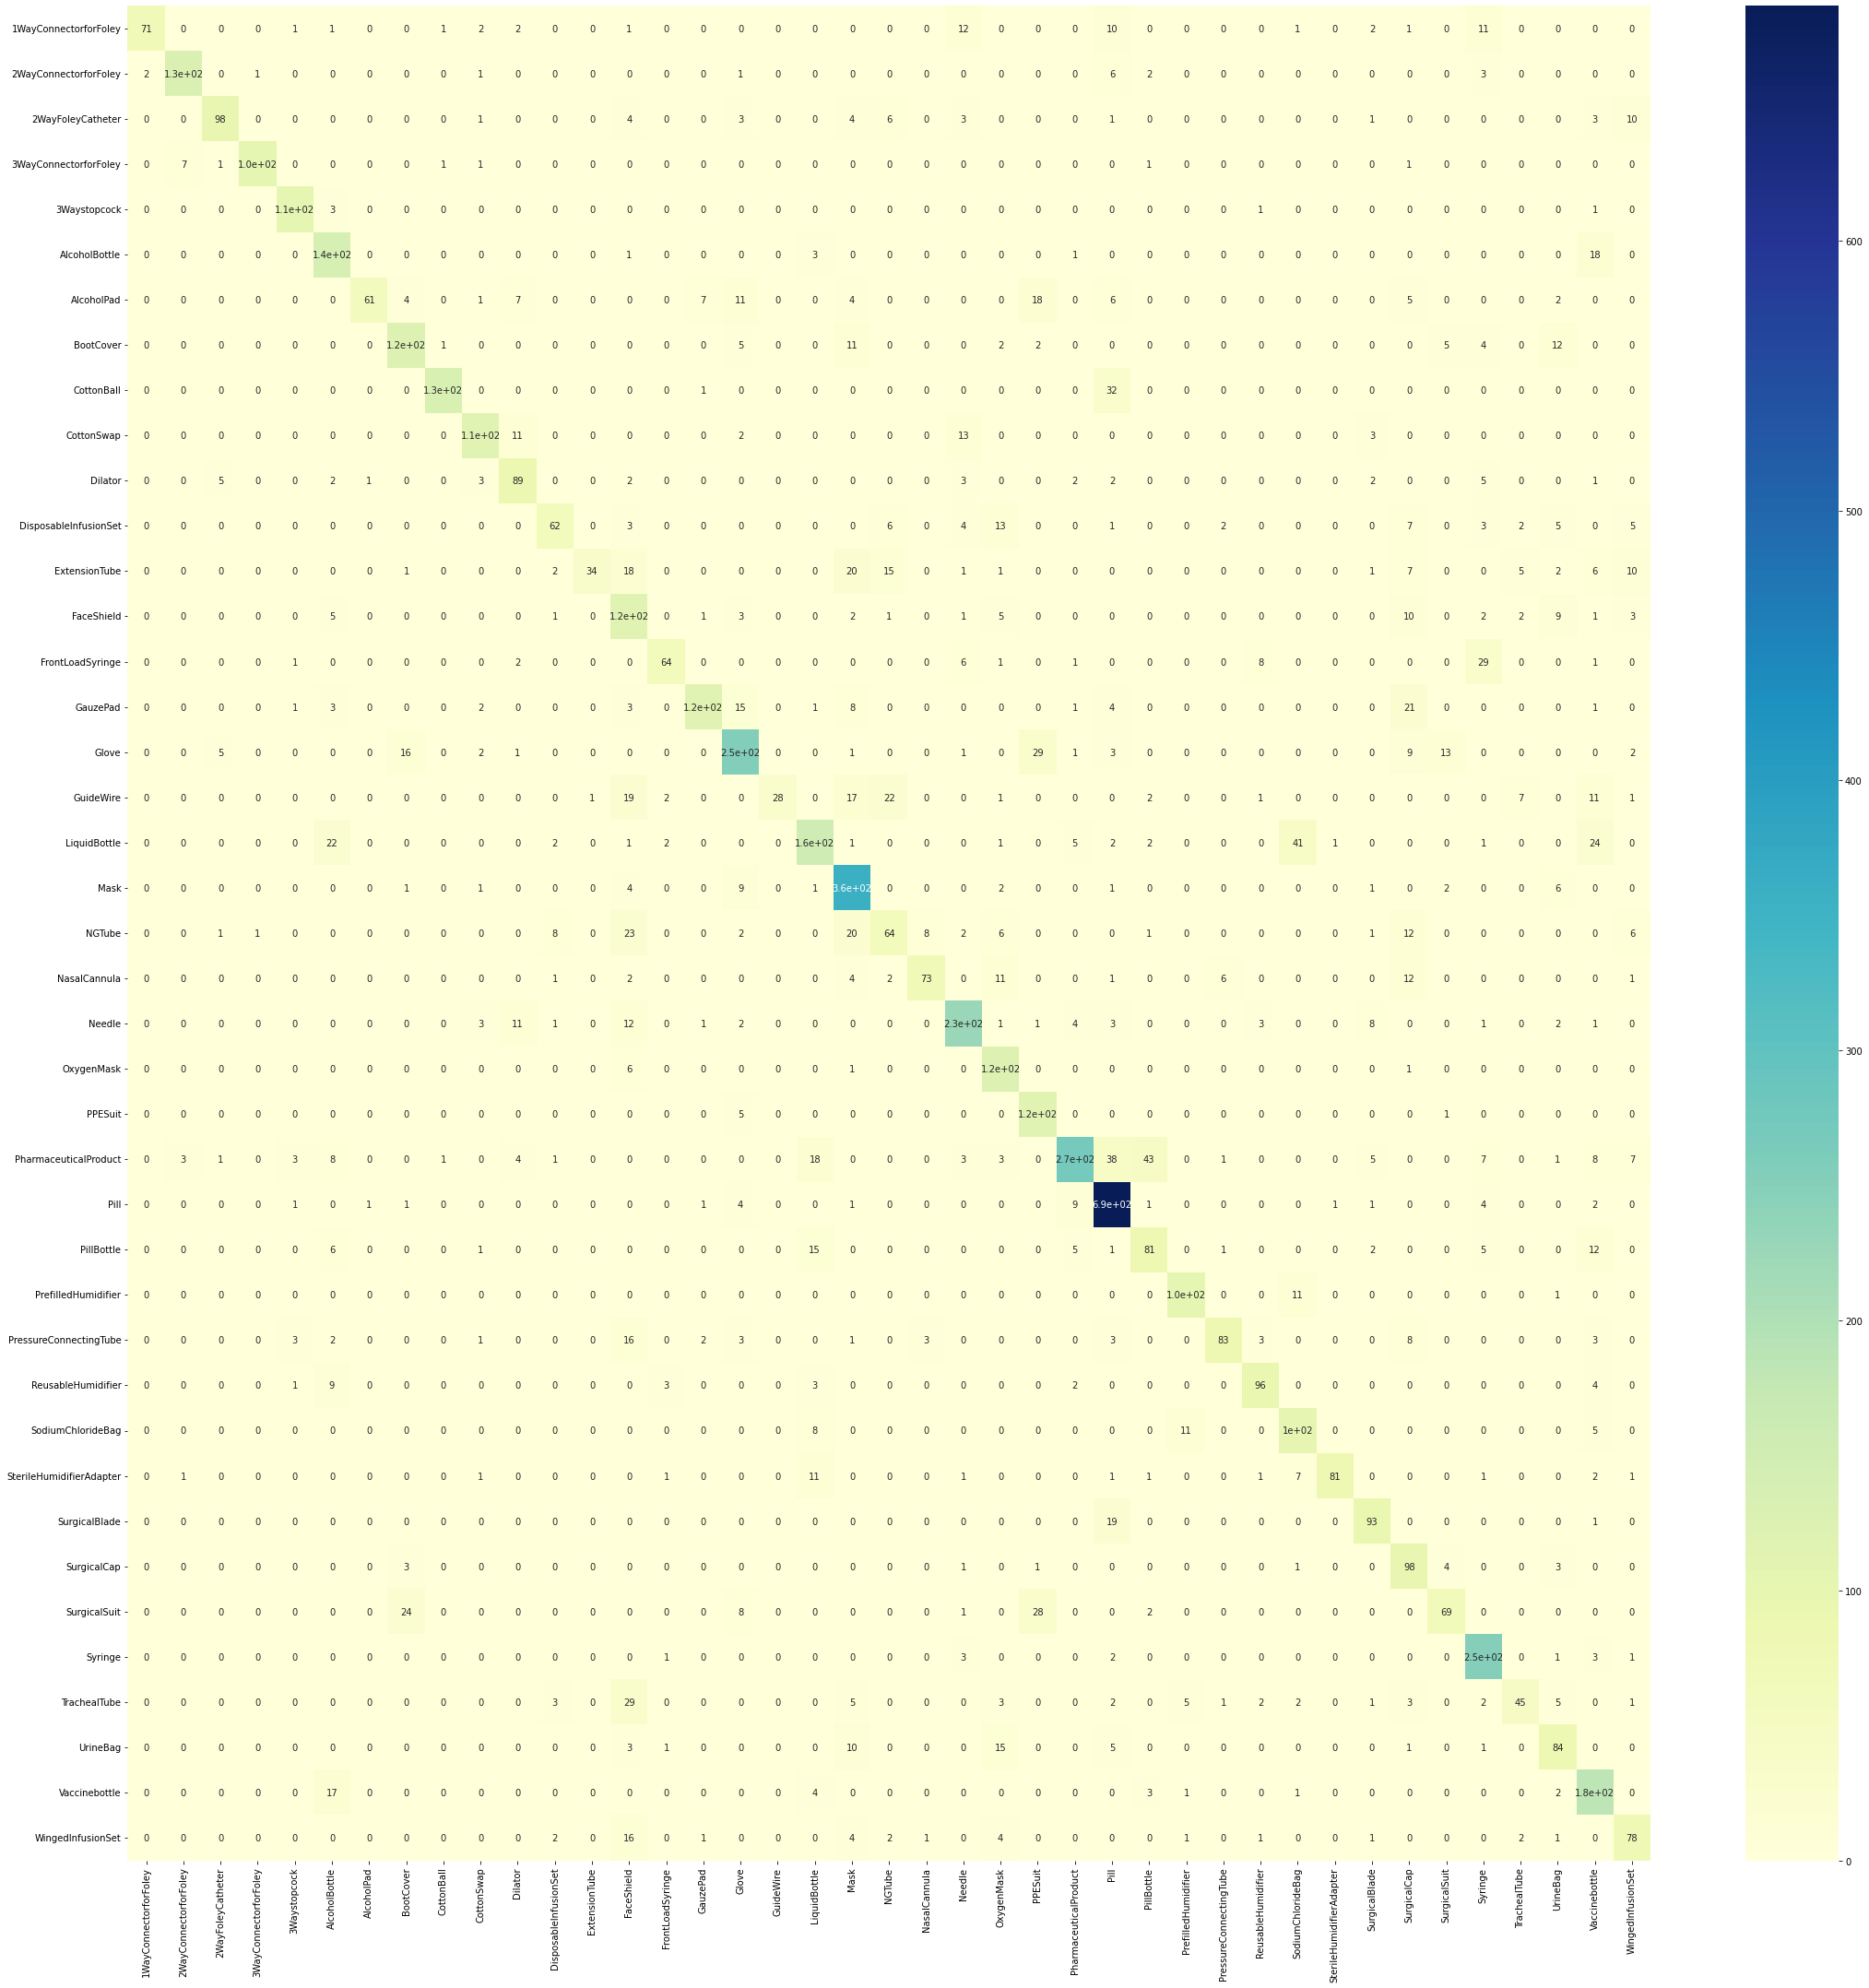

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

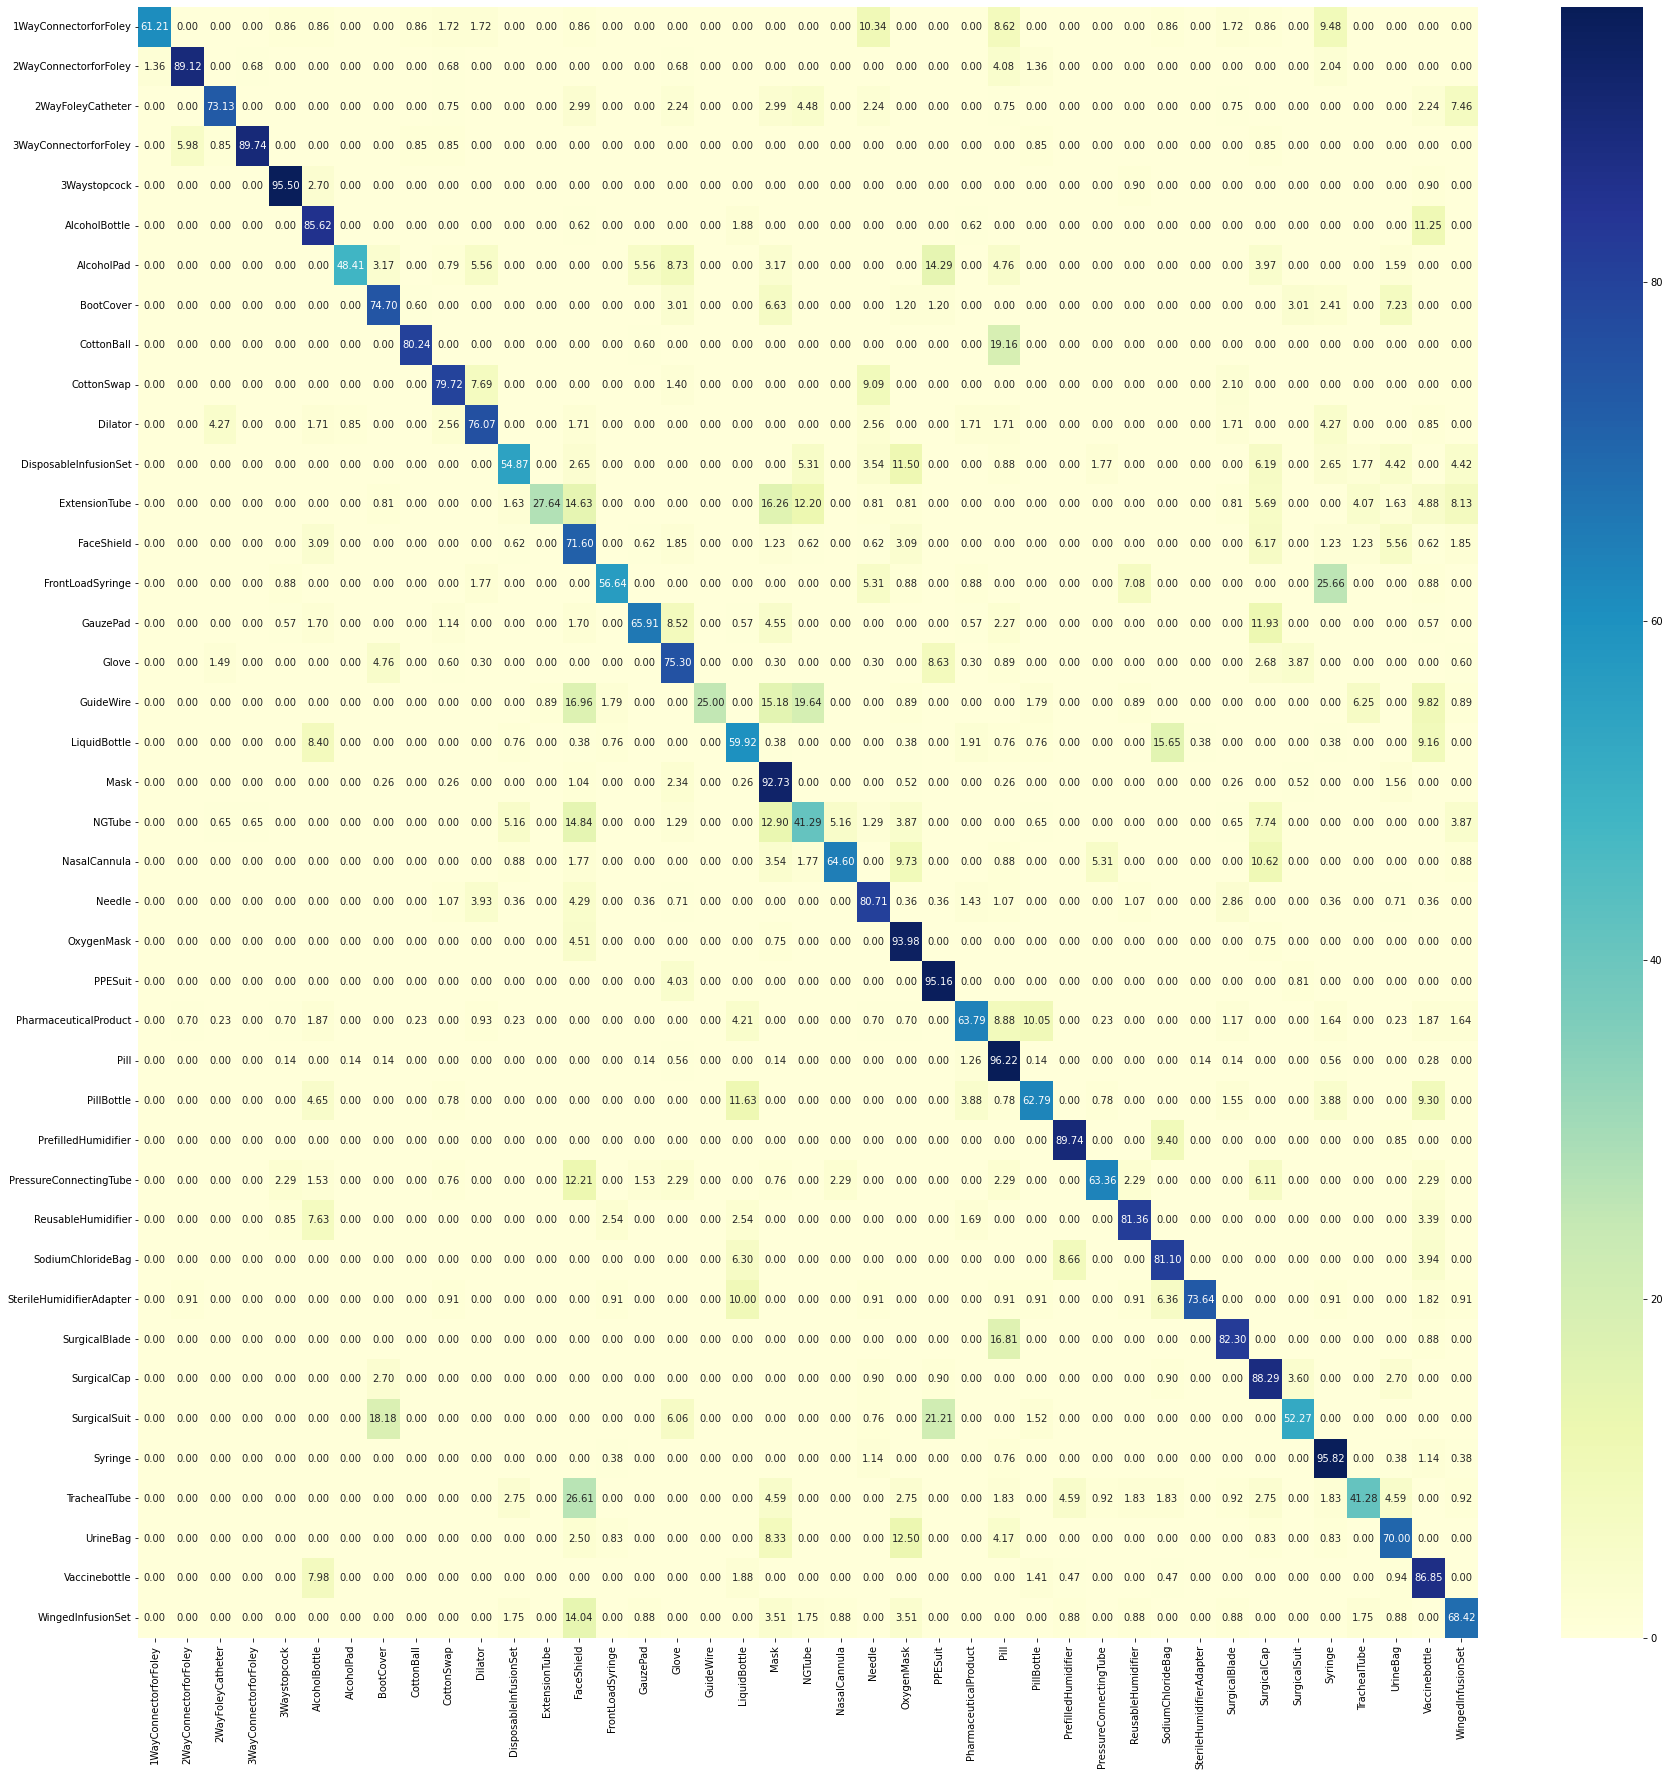

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")